In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.5 MB/s eta 0:00:00


# **STEP 1: improt libaraies**

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz

# **STEP 2 — Load Image & Mask**

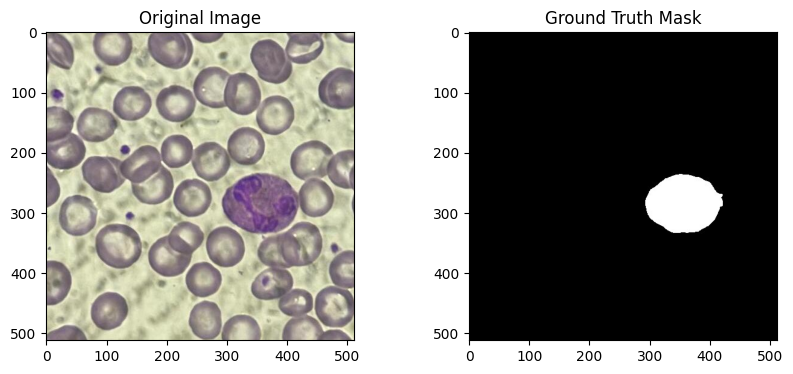

In [3]:
# Example image path
image_path = "/kaggle/input/datasets/kumarisejalshah/krd-wbc-dataset/Creating a white blood cell dataset for segmentation/KRD-WBC dataset/Dataset/image/image100.jpg"

mask_path = "/kaggle/input/datasets/kumarisejalshah/krd-wbc-dataset/Creating a white blood cell dataset for segmentation/KRD-WBC dataset/Dataset/mask/mask100.jpg"

# Read image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read mask (ground truth)
mask = cv2.imread(mask_path, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.show()

# **STEP 3 — Preprocessing**

In [4]:
image_blur = cv2.GaussianBlur(image, (5,5), 0)

# Convert to LAB color space (better separation)
image_lab = cv2.cvtColor(image_blur, cv2.COLOR_RGB2LAB)

h, w, c = image_lab.shape
pixels = image_lab.reshape((-1, 3))

# **STEP 4 — K-Means Clustering (Hard Clustering)**

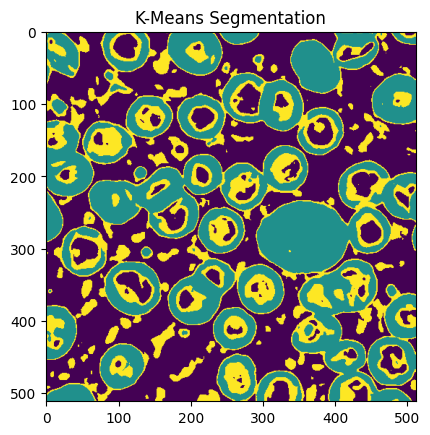

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(pixels)

seg_kmeans = labels_kmeans.reshape((h, w))

plt.imshow(seg_kmeans, cmap='viridis')
plt.title("K-Means Segmentation")
plt.show()

# **STEP 5 — Extract Nucleus Cluster (K-Means)**

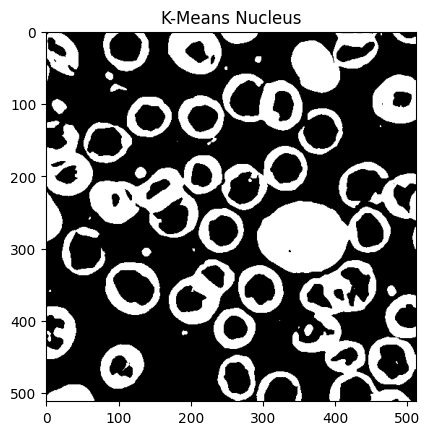

In [6]:
# Find cluster with lowest average intensity
cluster_means = []

for i in range(3):
    cluster_means.append(np.mean(pixels[labels_kmeans == i]))

nucleus_cluster = np.argmin(cluster_means)

nucleus_kmeans = (seg_kmeans == nucleus_cluster).astype(np.uint8)

plt.imshow(nucleus_kmeans, cmap='gray')
plt.title("K-Means Nucleus")
plt.show()

# **STEP 6 — Fuzzy C-Means (Soft Clustering)**

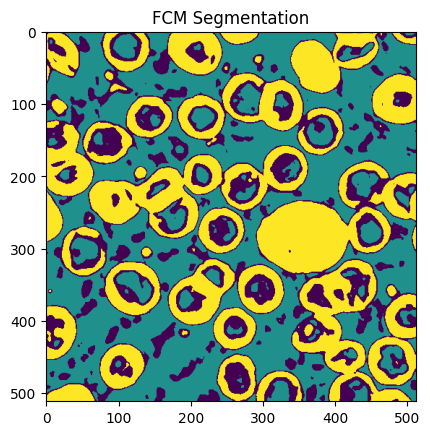

In [7]:
data = pixels.T

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data,
    c=3,
    m=2,
    error=0.005,
    maxiter=1000
)

labels_fcm = np.argmax(u, axis=0)
seg_fcm = labels_fcm.reshape((h, w))

plt.imshow(seg_fcm, cmap='viridis')
plt.title("FCM Segmentation")
plt.show()

# **STEP 7 — Extract Nucleus Cluster (FCM)**

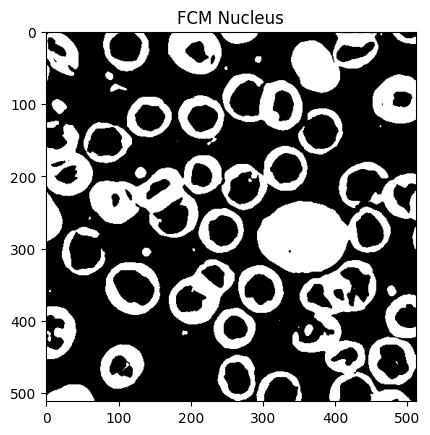

In [8]:
cluster_means_fcm = []

for i in range(3):
    cluster_means_fcm.append(np.mean(pixels[labels_fcm == i]))

nucleus_cluster_fcm = np.argmin(cluster_means_fcm)

nucleus_fcm = (seg_fcm == nucleus_cluster_fcm).astype(np.uint8)

plt.imshow(nucleus_fcm, cmap='gray')
plt.title("FCM Nucleus")
plt.show()


# **STEP 8 — Evaluation Metrics**

In [9]:
_, mask_binary = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)

# **Dice Score**

In [10]:
def dice_score(pred, gt):
    intersection = np.sum(pred * gt)
    return (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

# **IoU Score**

In [11]:
def iou_score(pred, gt):
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    return intersection / (union + 1e-8)

# **STEP 9 — Calculate Scores**

In [12]:
dice_kmeans = dice_score(nucleus_kmeans, mask_binary)
iou_kmeans = iou_score(nucleus_kmeans, mask_binary)

dice_fcm = dice_score(nucleus_fcm, mask_binary)
iou_fcm = iou_score(nucleus_fcm, mask_binary)

print("K-Means Dice:", dice_kmeans)
print("K-Means IoU:", iou_kmeans)

print("FCM Dice:", dice_fcm)
print("FCM IoU:", iou_fcm)

K-Means Dice: 0.1927443865052305
K-Means IoU: 0.10665031834235791
FCM Dice: 0.19353258206759416
FCM IoU: 0.1071331705993912


# **STEP 10: Avg IOU AND DICE (all image )**

# **Prepare dataset paths**

In [13]:
image_dir = "/kaggle/input/datasets/kumarisejalshah/krd-wbc-dataset/Creating a white blood cell dataset for segmentation/KRD-WBC dataset/Dataset/image"
mask_dir  = "/kaggle/input/datasets/kumarisejalshah/krd-wbc-dataset/Creating a white blood cell dataset for segmentation/KRD-WBC dataset/Dataset/mask"

import glob
image_paths = sorted(glob.glob(image_dir + "/*"))
mask_paths  = sorted(glob.glob(mask_dir + "/*"))

print(f"Total Images: {len(image_paths)}, Total Masks: {len(mask_paths)}")

Total Images: 600, Total Masks: 600


# **Initialize lists to store scores**

In [14]:
dice_kmeans_list = []
iou_kmeans_list = []

dice_fcm_list = []
iou_fcm_list = []

# **Loop over all images and calculate Dice & IoU**

In [15]:


for img_path, mask_path in zip(image_paths, mask_paths):
    
    # ---- Load Image ----
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_blur = cv2.GaussianBlur(image, (5,5), 0)
    image_lab = cv2.cvtColor(image_blur, cv2.COLOR_RGB2LAB)
    
    h, w, c = image_lab.shape
    pixels = image_lab.reshape((-1, 3))
    
    # ---- Load Mask ----
    mask = cv2.imread(mask_path, 0)
    _, mask_binary = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
    
    # -----------------------
    # K-MEANS
    # -----------------------
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels_kmeans = kmeans.fit_predict(pixels)
    seg_kmeans = labels_kmeans.reshape((h, w))
    
    cluster_means = [np.mean(pixels[labels_kmeans == i]) for i in range(3)]
    nucleus_cluster = np.argmin(cluster_means)
    nucleus_kmeans = (seg_kmeans == nucleus_cluster).astype(np.uint8)
    
    dice_kmeans_list.append(dice_score(nucleus_kmeans, mask_binary))
    iou_kmeans_list.append(iou_score(nucleus_kmeans, mask_binary))
    
    # -----------------------
    # FCM
    # -----------------------
    data = pixels.T
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data,
        c=3,
        m=2,
        error=0.005,
        maxiter=1000
    )
    
    labels_fcm = np.argmax(u, axis=0)
    seg_fcm = labels_fcm.reshape((h, w))
    
    cluster_means_fcm = [np.mean(pixels[labels_fcm == i]) for i in range(3)]
    nucleus_cluster_fcm = np.argmin(cluster_means_fcm)
    nucleus_fcm = (seg_fcm == nucleus_cluster_fcm).astype(np.uint8)
    
    dice_fcm_list.append(dice_score(nucleus_fcm, mask_binary))
    iou_fcm_list.append(iou_score(nucleus_fcm, mask_binary))

# **Compute Average Dice & IoU**

In [16]:
avg_dice_kmeans = np.mean(dice_kmeans_list)
avg_iou_kmeans  = np.mean(iou_kmeans_list)

avg_dice_fcm = np.mean(dice_fcm_list)
avg_iou_fcm  = np.mean(iou_fcm_list)

print("===== AVERAGE SEGMENTATION SCORES =====")
print(f"K-Means -> Dice: {avg_dice_kmeans:.4f}, IoU: {avg_iou_kmeans:.4f}")
print(f"FCM     -> Dice: {avg_dice_fcm:.4f}, IoU: {avg_iou_fcm:.4f}")

===== AVERAGE SEGMENTATION SCORES =====
K-Means -> Dice: 0.2647, IoU: 0.1724
FCM     -> Dice: 0.2420, IoU: 0.1507
